In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, average_precision_score, precision_recall_curve
from xgboost import XGBClassifier 
import warnings; warnings.filterwarnings('ignore')

In [24]:
# 1. DATA PREPARATION & FEATURE ENGINEERING
df = pd.read_csv(r'C:\Users\Sumit\Downloads\archive (11)\netflix_customer_churn.csv')
df.to_csv('Churn')
df.head()

,customer_id,age,gender,subscription_type,watch_hours,last_login_days,region,device,monthly_fee,churned,payment_method,number_of_profiles,avg_watch_time_per_day,favorite_genre
0,a9b75100-82a8-427a-a208-72f24052884a,51,Other,Basic,14.73,29,Africa,TV,8.99,1,Gift Card,1,0.49,Action
1,49a5dfd9-7e69-4022-a6ad-0a1b9767fb5b,47,Other,Standard,0.70,19,Europe,Mobile,13.99,1,Gift Card,5,0.03,Sci-Fi
2,4d71f6ce-fca9-4ff7-8afa-197ac24de14b,27,Female,Standard,16.32,10,Asia,TV,13.99,0,Crypto,2,1.48,Drama
3,d3c72c38-631b-4f9e-8a0e-de103cad1a7d,53,Other,Premium,4.51,12,Oceania,TV,17.99,1,Crypto,2,0.35,Horror
4,4e265c34-103a-4dbb-9553-76c9aa47e946,56,Other,Standard,1.89,13,Africa,Mobile,13.99,1,Crypto,2,0.13,Action


In [25]:
# 2. Feature Engineering
np.random.seed(42)
df['tenure'] = np.random.randint(1, 72, size=len(df)) # Months of subscription
df['contract_type'] = df['subscription_type']        # Mapping for clarity
df['service_usage'] = df['watch_hours']              # Service usage metric
df.head()

,customer_id,age,gender,subscription_type,watch_hours,last_login_days,region,device,monthly_fee,churned,payment_method,number_of_profiles,avg_watch_time_per_day,favorite_genre,tenure,contract_type,service_usage
0,a9b75100-82a8-427a-a208-72f24052884a,51,Other,Basic,14.73,29,Africa,TV,8.99,1,Gift Card,1,0.49,Action,52,Basic,14.73
1,49a5dfd9-7e69-4022-a6ad-0a1b9767fb5b,47,Other,Standard,0.70,19,Europe,Mobile,13.99,1,Gift Card,5,0.03,Sci-Fi,15,Standard,0.70
2,4d71f6ce-fca9-4ff7-8afa-197ac24de14b,27,Female,Standard,16.32,10,Asia,TV,13.99,0,Crypto,2,1.48,Drama,61,Standard,16.32
3,d3c72c38-631b-4f9e-8a0e-de103cad1a7d,53,Other,Premium,4.51,12,Oceania,TV,17.99,1,Crypto,2,0.35,Horror,21,Premium,4.51
4,4e265c34-103a-4dbb-9553-76c9aa47e946,56,Other,Standard,1.89,13,Africa,Mobile,13.99,1,Crypto,2,0.13,Action,24,Standard,1.89


In [26]:
df['churned'].value_counts()

churned
1    2515
0    2485
Name: count, dtype: int64

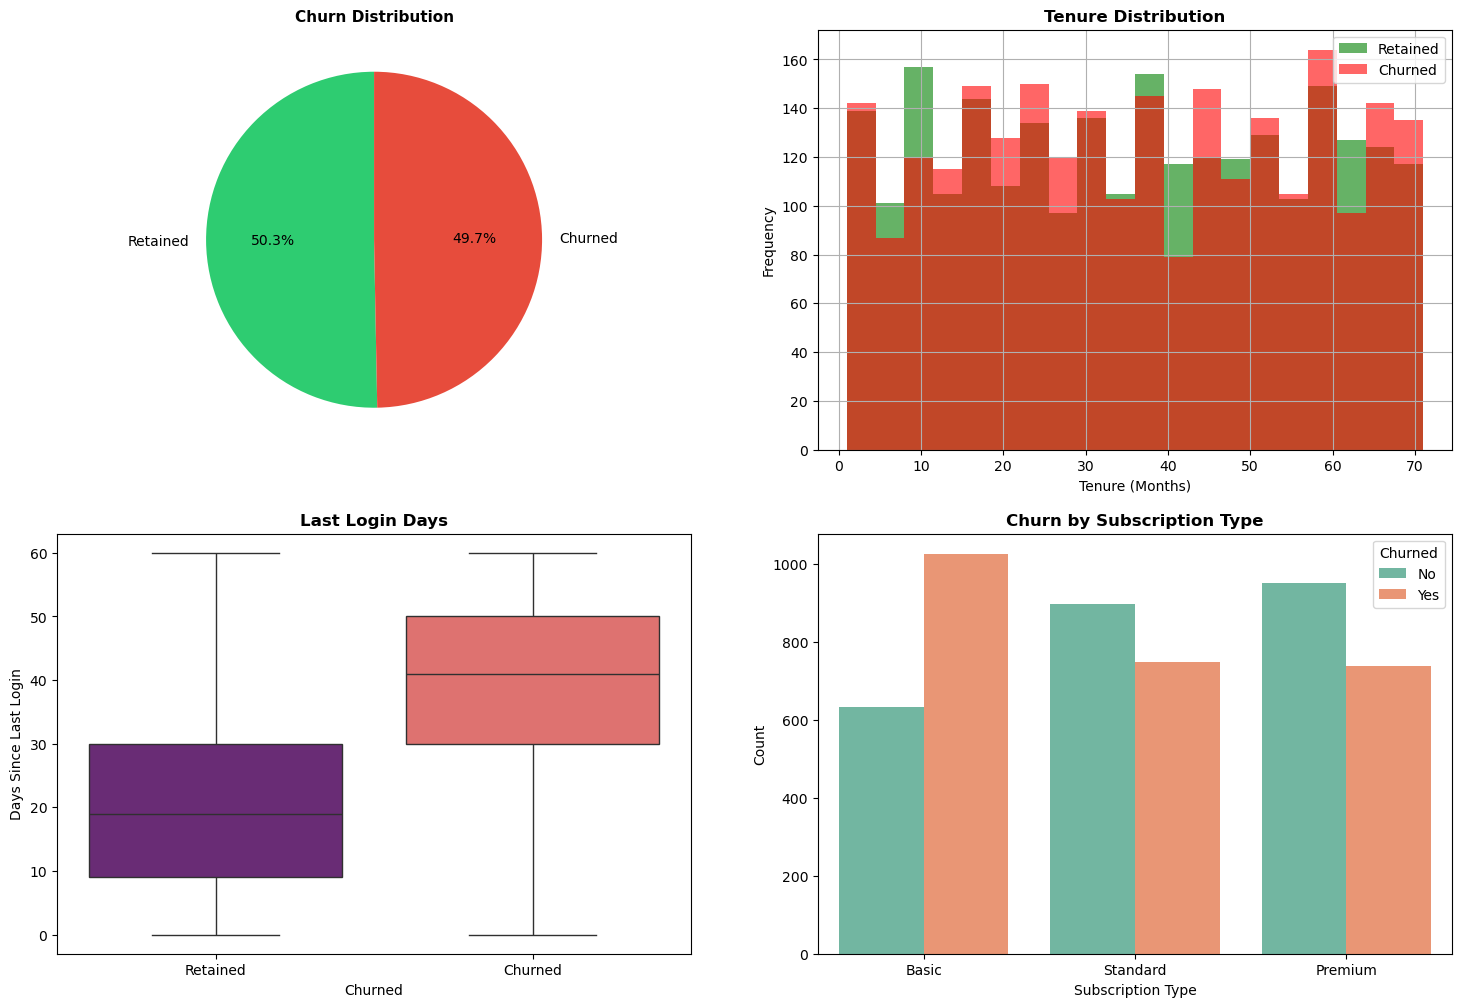

In [27]:
fig = plt.figure(figsize=(18, 12))
ax1 = plt.subplot(2, 2, 1)
churn_counts = df['churned'].value_counts()
colors_pie = ['#2ecc71', '#e74c3c']
plt.pie(churn_counts, labels=['Retained', 'Churned'], autopct='%1.1f%%', 
        colors=colors_pie, startangle=90)
plt.title('Churn Distribution', fontsize=11, fontweight='bold')

ax2 = plt.subplot(2, 2, 2)
df[df['churned']==0]['tenure'].hist(alpha=0.6, bins=20, label='Retained', color='green')
df[df['churned']==1]['tenure'].hist(alpha=0.6, bins=20, label='Churned', color='red')
plt.xlabel('Tenure (Months)')
plt.ylabel('Frequency')
plt.title('Tenure Distribution', fontweight='bold')
plt.legend()

ax3 = plt.subplot(2, 2, 3)
sns.boxplot(data=df, x='churned', y='last_login_days', palette='magma')
plt.title('Last Login Days', fontweight='bold')
plt.xlabel('Churned')
plt.ylabel('Days Since Last Login')
plt.xticks([0, 1], ['Retained', 'Churned'])

ax4 = plt.subplot(2, 2, 4)
sns.countplot(data=df, x='subscription_type', hue='churned', palette='Set2')
plt.title('Churn by Subscription Type', fontweight='bold')
plt.xlabel('Subscription Type')
plt.ylabel('Count')
plt.legend(title='Churned', labels=['No', 'Yes'])

In [28]:
num_neg = len(df[df['churned'] == 0])
num_pos = len(df[df['churned'] == 1])
scale_pos_weight_value = num_neg / num_pos

print(f"Calculated scale_pos_weight: {scale_pos_weight_value:.2f}")

Calculated scale_pos_weight: 0.99


In [29]:
# 3. SELECTING FEATURES
features = ['age', 'tenure', 'service_usage', 'monthly_fee', 'number_of_profiles', 
            'contract_type', 'gender', 'region', 'device', 'payment_method']
X = df[features]
y = df['churned']

# One-hot encoding for categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

In [30]:
# 4. TRAIN-TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [31]:
# 5. XGBOOST MODELING & OPTIMIZATION
xgb_model = XGBClassifier(
    scale_pos_weight=scale_pos_weight_value, 
    eval_metric='aucpr',
    use_label_encoder=False,
    random_state=42
)

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]
}

search = RandomizedSearchCV(xgb_model, param_grid, n_iter=5, cv=3, scoring='average_precision')
search.fit(X_train, y_train)
best_model = search.best_estimator_
xgb_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [32]:
# 6. EVALUATION 
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print(f"Final Model Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print(f"Area Under Precision-Recall Curve (AUPRC): {average_precision_score(y_test, y_prob):.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Final Model Accuracy: 75.40%
Area Under Precision-Recall Curve (AUPRC): 0.87

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.78      0.76       498
           1       0.77      0.73      0.75       502

    accuracy                           0.75      1000
   macro avg       0.75      0.75      0.75      1000
weighted avg       0.75      0.75      0.75      1000



In [33]:
# 7. BUSINESS ROI: REVENUE IMPACT ANALYSIS
test_data = df.loc[y_test.index].copy()
test_data['churn_prob'] = y_prob
# Target high-risk users (Prob > 0.7) for retention
high_risk = test_data[test_data['churn_prob'] > 0.7]
potential_saved_revenue = high_risk['monthly_fee'].sum() * 0.20 # 20% success rate

print(f"Potential Revenue Saved via 20% Retention: ${potential_saved_revenue:,.2f}")

Potential Revenue Saved via 20% Retention: $821.37
